<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/MobileNet(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 3.7 MB/s 
     |████████████████████████████████| 37.1 MB 1.7 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석

* Depthwise Separable Convolution 

이것이 전부이다. 이 외에 Width Multiplier(채널 수를 어느 비율로 줄일지) Resolution Multiplier(화질을 어느 비율로 줄일지)가 있지만 전혀 어려운 내용이 아니므로, Depthwise Separable Convolution 만 알아보자.

---

## Depthwise Separable Convolution

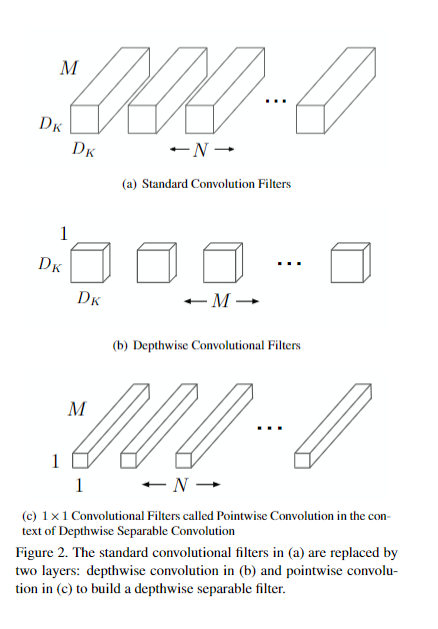

* 원래의 conv연산은 그림(a)와 같이 DxDxM 짜리 필터를 N번 하여서 만들어진다. DxD커널을 인풋에 적용하고 이것을 M채널의 수 만큼 반복 후 더해서 하나의 필터맵 output을 만들어낸다. 이걸 N회 하여 N개의 결과를 낸다.

* N개의 필터연산중 1개의 연산만을 자세히 파보자. 가령 DxDxM 짜리 필터 하나를 연산 할 때, 이 연산을 M개의 DxDx1 , 1개의 1x1xM 으로 나눌 수 있다.

    > 1) Depthwise Convolutional Filters  : M개의 DxDx1 필터, M번 결과를 더해서 다 더하는 것이 아니라. 그대로 한 필터씩 쌓아서 출력을 만든다.

    > 2)  1x1Convolutional Filters called Pointwise Convolution : 1x1xM필터, 앞에서 나온 결과물에 적용하여 채널을 압축한다. 


이 과정을 N번 반복하면, 원래의 conv연산과 동일하게 볼 수 있다.

* 그 결과 아래 만큼 계산량을 줄일 수 있었다.

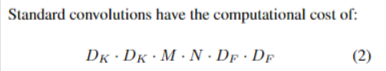

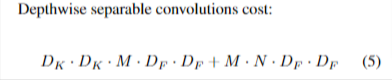

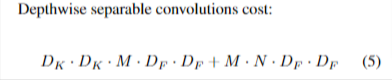


---


# 3. 구현

* Depthwise separable convolution 만 구현하면 된다.




---







## 기본구조 구현

In [ ]:
def conv_block(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 'valid' , **kwargs) :
    """ 
    conv들이 기본적으로 ReLU를 가지고 있고,
    성능향상을 위해서 BN층도 추가하여 block으로 만든다.
    BN을 사용하므로 bias는 False로 둔다.
    """
    output = nn.Sequential(
       nn.Conv2d(in_channels, out_channels, kernel_size ,stride, padding ,bias =False, **kwargs),
       nn.BatchNorm2d(out_channels),
       nn.ReLU()
    )
    return output

## Depthwise separable convolution구현

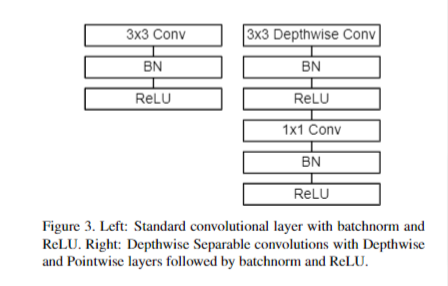

In [ ]:
class DSC_block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1 , **kwargs) :
        super(DSC_block, self).__init__()
        
        # groups = in_channels로 두면 그만큼 나눠서 작동하겠다는 이야기
        # 인채널수와 동일한 값을 넣었으니까 한채널당 1회 연산하여 결과를 내겠다.
        self.depthwise = conv_block(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels )
        self.pointwise = conv_block(in_channels, out_channels, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

## MobileNet 구현

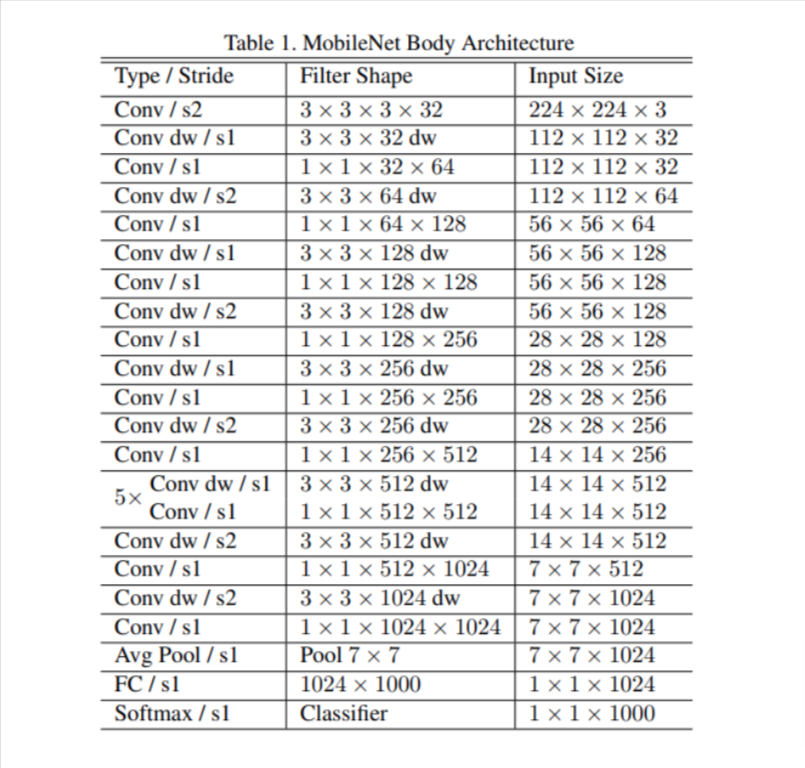

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNet, self).__init__()    

        self.conv1 = conv_block(3, 32, kernel_size=3, stride=2, padding =1)
        self.conv2 = DSC_block(32, 64, stride=1)
        self.conv3 = DSC_block(64, 128, stride=2)
        self.conv4 = DSC_block(128, 128, stride=1)
        self.conv5 = DSC_block(128, 256, stride=2)
        self.conv6 = DSC_block(256, 256, stride=1)
        self.conv7 = DSC_block(256, 512, stride=2)
        self.conv8 = DSC_block(512, 512, stride=1)
        self.conv9 = DSC_block(512, 512, stride=1)
        self.conv10 = DSC_block(512, 512, stride=1)
        self.conv11 = DSC_block(512, 512, stride=1)
        self.conv12 = DSC_block(512, 512, stride=1)
        self.conv13 = DSC_block(512, 1024, stride=2)
        self.conv14 = DSC_block(1024, 1024, stride=1)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1)),
            nn.Flatten(),
            nn.Linear(1024, num_classes)
        )

        self._initialize_weights()
    


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)



    def forward(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.classifier(x)
        return x



In [ ]:
# 모델 확인
model = MobileNet().to(device)
summary(model, (3,224,224))
    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        DSC_block-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

---
# 4. 데이터 전처리
---

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
labels.shape

torch.Size([7])

(3, 96, 96)
torch.Size([3, 96, 96])


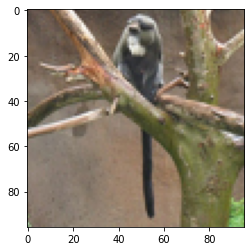

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


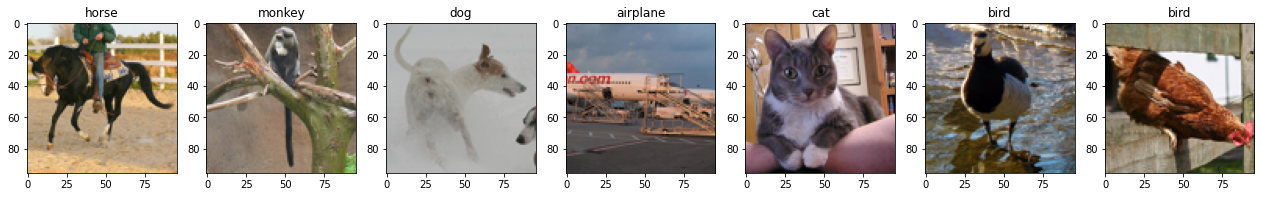

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




---
# 5. 학습 및 평가
---

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = MobileNet(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')


# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[1] Train Loss: 2.1462, Accuracy: 18.04%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


[1] Validation Loss: 1.8459, Accuracy: 28.68%
Validation loss decreased (inf --> 1.845929).



Epoch: 2. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[2] Train Loss: 1.8158, Accuracy: 27.85%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.23it/s]


[2] Validation Loss: 1.6885, Accuracy: 32.34%
Validation loss decreased (1.845929 --> 1.688542).



Epoch: 3. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[3] Train Loss: 1.7468, Accuracy: 30.52%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.27it/s]


[3] Validation Loss: 1.6160, Accuracy: 35.46%
Validation loss decreased (1.688542 --> 1.615975).



Epoch: 4. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[4] Train Loss: 1.7147, Accuracy: 32.79%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.24it/s]


[4] Validation Loss: 1.6320, Accuracy: 33.14%
EarlyStopping counter: 1 out of 15



Epoch: 5. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[5] Train Loss: 1.6781, Accuracy: 34.21%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.28it/s]


[5] Validation Loss: 1.5759, Accuracy: 37.60%
Validation loss decreased (1.615975 --> 1.575854).



Epoch: 6. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[6] Train Loss: 1.6505, Accuracy: 35.65%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.31it/s]


[6] Validation Loss: 1.5502, Accuracy: 38.26%
Validation loss decreased (1.575854 --> 1.550241).



Epoch: 7. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[7] Train Loss: 1.6059, Accuracy: 38.14%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


[7] Validation Loss: 1.6110, Accuracy: 37.06%
EarlyStopping counter: 1 out of 15



Epoch: 8. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[8] Train Loss: 1.5867, Accuracy: 39.04%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[8] Validation Loss: 1.5538, Accuracy: 39.50%
EarlyStopping counter: 2 out of 15



Epoch: 9. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[9] Train Loss: 1.5580, Accuracy: 40.11%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.30it/s]


[9] Validation Loss: 1.4913, Accuracy: 43.12%
Validation loss decreased (1.550241 --> 1.491321).



Epoch: 10. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[10] Train Loss: 1.5368, Accuracy: 42.31%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s]


[10] Validation Loss: 1.5050, Accuracy: 43.00%
EarlyStopping counter: 1 out of 15



Epoch: 11. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[11] Train Loss: 1.5202, Accuracy: 42.71%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


[11] Validation Loss: 1.4841, Accuracy: 43.94%
Validation loss decreased (1.491321 --> 1.484126).



Epoch: 12. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[12] Train Loss: 1.5030, Accuracy: 43.76%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.26it/s]


[12] Validation Loss: 1.4580, Accuracy: 44.86%
Validation loss decreased (1.484126 --> 1.458000).



Epoch: 13. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[13] Train Loss: 1.4960, Accuracy: 44.39%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.29it/s]


[13] Validation Loss: 1.4228, Accuracy: 46.52%
Validation loss decreased (1.458000 --> 1.422799).



Epoch: 14. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[14] Train Loss: 1.4811, Accuracy: 45.21%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


[14] Validation Loss: 1.3824, Accuracy: 46.92%
Validation loss decreased (1.422799 --> 1.382369).



Epoch: 15. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[15] Train Loss: 1.4616, Accuracy: 44.80%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


[15] Validation Loss: 1.3586, Accuracy: 48.44%
Validation loss decreased (1.382369 --> 1.358608).



Epoch: 16. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[16] Train Loss: 1.4614, Accuracy: 45.44%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


[16] Validation Loss: 1.3745, Accuracy: 48.28%
EarlyStopping counter: 1 out of 15



Epoch: 17. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[17] Train Loss: 1.4257, Accuracy: 46.39%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


[17] Validation Loss: 1.4110, Accuracy: 48.66%
EarlyStopping counter: 2 out of 15



Epoch: 18. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[18] Train Loss: 1.4218, Accuracy: 46.90%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.22it/s]


[18] Validation Loss: 1.3401, Accuracy: 49.70%
Validation loss decreased (1.358608 --> 1.340096).



Epoch: 19. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[19] Train Loss: 1.4205, Accuracy: 47.46%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[19] Validation Loss: 1.3611, Accuracy: 48.70%
EarlyStopping counter: 1 out of 15



Epoch: 20. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[20] Train Loss: 1.3904, Accuracy: 48.06%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


[20] Validation Loss: 1.2761, Accuracy: 52.32%
Validation loss decreased (1.340096 --> 1.276093).



Epoch: 21. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[21] Train Loss: 1.3883, Accuracy: 47.83%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


[21] Validation Loss: 1.2612, Accuracy: 52.88%
Validation loss decreased (1.276093 --> 1.261212).



Epoch: 22. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[22] Train Loss: 1.3660, Accuracy: 49.84%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[22] Validation Loss: 1.3288, Accuracy: 50.24%
EarlyStopping counter: 1 out of 15



Epoch: 23. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[23] Train Loss: 1.3454, Accuracy: 50.12%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


[23] Validation Loss: 1.3370, Accuracy: 49.48%
EarlyStopping counter: 2 out of 15



Epoch: 24. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[24] Train Loss: 1.3403, Accuracy: 50.30%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


[24] Validation Loss: 1.2347, Accuracy: 54.28%
Validation loss decreased (1.261212 --> 1.234663).



Epoch: 25. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[25] Train Loss: 1.3306, Accuracy: 51.04%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


[25] Validation Loss: 1.2323, Accuracy: 54.90%
Validation loss decreased (1.234663 --> 1.232255).



Epoch: 26. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[26] Train Loss: 1.3067, Accuracy: 51.80%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[26] Validation Loss: 1.3379, Accuracy: 51.48%
EarlyStopping counter: 1 out of 15



Epoch: 27. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[27] Train Loss: 1.3112, Accuracy: 51.35%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[27] Validation Loss: 1.2370, Accuracy: 54.76%
EarlyStopping counter: 2 out of 15



Epoch: 28. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[28] Train Loss: 1.2902, Accuracy: 52.90%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


[28] Validation Loss: 1.2270, Accuracy: 55.32%
Validation loss decreased (1.232255 --> 1.226972).



Epoch: 29. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[29] Train Loss: 1.2862, Accuracy: 52.75%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[29] Validation Loss: 1.2513, Accuracy: 53.76%
EarlyStopping counter: 1 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[30] Train Loss: 1.2783, Accuracy: 52.71%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


[30] Validation Loss: 1.2414, Accuracy: 55.38%
EarlyStopping counter: 2 out of 15



Epoch: 31. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[31] Train Loss: 1.2613, Accuracy: 53.80%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[31] Validation Loss: 1.2183, Accuracy: 56.22%
Validation loss decreased (1.226972 --> 1.218265).



Epoch: 32. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[32] Train Loss: 1.2741, Accuracy: 53.56%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[32] Validation Loss: 1.1691, Accuracy: 57.26%
Validation loss decreased (1.218265 --> 1.169135).



Epoch: 33. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[33] Train Loss: 1.2451, Accuracy: 53.83%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[33] Validation Loss: 1.2726, Accuracy: 54.12%
EarlyStopping counter: 1 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[34] Train Loss: 1.2413, Accuracy: 53.99%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


[34] Validation Loss: 1.1376, Accuracy: 58.28%
Validation loss decreased (1.169135 --> 1.137608).



Epoch: 35. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[35] Train Loss: 1.2228, Accuracy: 54.98%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[35] Validation Loss: 1.1323, Accuracy: 58.46%
Validation loss decreased (1.137608 --> 1.132255).



Epoch: 36. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[36] Train Loss: 1.2219, Accuracy: 54.79%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


[36] Validation Loss: 1.1794, Accuracy: 56.86%
EarlyStopping counter: 1 out of 15



Epoch: 37. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[37] Train Loss: 1.2104, Accuracy: 56.31%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


[37] Validation Loss: 1.1516, Accuracy: 58.22%
EarlyStopping counter: 2 out of 15



Epoch: 38. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[38] Train Loss: 1.2004, Accuracy: 56.49%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


[38] Validation Loss: 1.1682, Accuracy: 57.72%
EarlyStopping counter: 3 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[39] Train Loss: 1.1850, Accuracy: 56.61%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


[39] Validation Loss: 1.1438, Accuracy: 57.72%
EarlyStopping counter: 4 out of 15



Epoch: 40. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[40] Train Loss: 1.1771, Accuracy: 57.10%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.19it/s]


[40] Validation Loss: 1.1512, Accuracy: 58.88%
EarlyStopping counter: 5 out of 15



Epoch: 41. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[41] Train Loss: 1.1644, Accuracy: 57.77%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[41] Validation Loss: 1.1672, Accuracy: 57.00%
EarlyStopping counter: 6 out of 15



Epoch: 42. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[42] Train Loss: 1.1643, Accuracy: 57.27%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


[42] Validation Loss: 1.2080, Accuracy: 55.64%
EarlyStopping counter: 7 out of 15



Epoch: 43. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[43] Train Loss: 1.1594, Accuracy: 57.80%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


[43] Validation Loss: 1.0840, Accuracy: 61.18%
Validation loss decreased (1.132255 --> 1.083976).



Epoch: 44. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[44] Train Loss: 1.1547, Accuracy: 57.69%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[44] Validation Loss: 1.0911, Accuracy: 60.92%
EarlyStopping counter: 1 out of 15



Epoch: 45. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[45] Train Loss: 1.1447, Accuracy: 58.34%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


[45] Validation Loss: 1.0662, Accuracy: 61.38%
Validation loss decreased (1.083976 --> 1.066214).



Epoch: 46. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[46] Train Loss: 1.1277, Accuracy: 58.56%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.18it/s]


[46] Validation Loss: 1.1003, Accuracy: 60.72%
EarlyStopping counter: 1 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[47] Train Loss: 1.1150, Accuracy: 59.61%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[47] Validation Loss: 1.0958, Accuracy: 60.20%
EarlyStopping counter: 2 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[48] Train Loss: 1.1151, Accuracy: 59.74%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


[48] Validation Loss: 1.1158, Accuracy: 60.46%
EarlyStopping counter: 3 out of 15



Epoch: 49. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[49] Train Loss: 1.1311, Accuracy: 58.83%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.21it/s]


[49] Validation Loss: 1.0617, Accuracy: 62.16%
Validation loss decreased (1.066214 --> 1.061702).



Epoch: 50. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[50] Train Loss: 1.0902, Accuracy: 60.40%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.20it/s]


[50] Validation Loss: 1.0856, Accuracy: 61.18%
EarlyStopping counter: 1 out of 15



Epoch: 51. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[51] Train Loss: 1.0787, Accuracy: 60.81%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[51] Validation Loss: 1.0870, Accuracy: 60.24%
EarlyStopping counter: 2 out of 15



Epoch: 52. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[52] Train Loss: 1.0837, Accuracy: 60.55%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


[52] Validation Loss: 1.0314, Accuracy: 63.12%
Validation loss decreased (1.061702 --> 1.031380).



Epoch: 53. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[53] Train Loss: 1.0783, Accuracy: 60.67%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


[53] Validation Loss: 1.0680, Accuracy: 61.64%
EarlyStopping counter: 1 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[54] Train Loss: 1.0605, Accuracy: 61.60%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[54] Validation Loss: 1.0881, Accuracy: 60.76%
EarlyStopping counter: 2 out of 15



Epoch: 55. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[55] Train Loss: 1.0523, Accuracy: 61.76%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


[55] Validation Loss: 1.0467, Accuracy: 62.00%
EarlyStopping counter: 3 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[56] Train Loss: 1.0402, Accuracy: 62.86%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


[56] Validation Loss: 1.0366, Accuracy: 63.00%
EarlyStopping counter: 4 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[57] Train Loss: 1.0302, Accuracy: 62.84%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.04it/s]


[57] Validation Loss: 1.0249, Accuracy: 63.66%
Validation loss decreased (1.031380 --> 1.024898).



Epoch: 58. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]


[58] Train Loss: 1.0373, Accuracy: 62.64%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.16it/s]


[58] Validation Loss: 1.0460, Accuracy: 62.58%
EarlyStopping counter: 1 out of 15



Epoch: 59. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[59] Train Loss: 1.0253, Accuracy: 62.88%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


[59] Validation Loss: 1.0204, Accuracy: 64.18%
Validation loss decreased (1.024898 --> 1.020356).



Epoch: 60. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[60] Train Loss: 1.0111, Accuracy: 63.70%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[60] Validation Loss: 1.0311, Accuracy: 63.74%
EarlyStopping counter: 1 out of 15



Epoch: 61. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[61] Train Loss: 1.0062, Accuracy: 63.51%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


[61] Validation Loss: 1.0453, Accuracy: 62.46%
EarlyStopping counter: 2 out of 15



Epoch: 62. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[62] Train Loss: 1.0093, Accuracy: 63.54%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


[62] Validation Loss: 0.9929, Accuracy: 65.06%
Validation loss decreased (1.020356 --> 0.992887).



Epoch: 63. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[63] Train Loss: 0.9962, Accuracy: 64.42%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.17it/s]


[63] Validation Loss: 1.0269, Accuracy: 63.26%
EarlyStopping counter: 1 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[64] Train Loss: 0.9836, Accuracy: 64.61%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


[64] Validation Loss: 1.0009, Accuracy: 64.50%
EarlyStopping counter: 2 out of 15



Epoch: 65. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[65] Train Loss: 0.9858, Accuracy: 64.54%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.00it/s]


[65] Validation Loss: 0.9655, Accuracy: 65.04%
Validation loss decreased (0.992887 --> 0.965511).



Epoch: 66. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[66] Train Loss: 0.9580, Accuracy: 65.50%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


[66] Validation Loss: 0.9994, Accuracy: 64.46%
EarlyStopping counter: 1 out of 15



Epoch: 67. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[67] Train Loss: 0.9622, Accuracy: 65.60%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.15it/s]


[67] Validation Loss: 0.9701, Accuracy: 65.38%
EarlyStopping counter: 2 out of 15



Epoch: 68. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[68] Train Loss: 0.9640, Accuracy: 64.89%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


[68] Validation Loss: 1.0016, Accuracy: 64.40%
EarlyStopping counter: 3 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[69] Train Loss: 0.9592, Accuracy: 65.42%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


[69] Validation Loss: 1.1196, Accuracy: 61.32%
EarlyStopping counter: 4 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[70] Train Loss: 0.9448, Accuracy: 65.99%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.97it/s]


[70] Validation Loss: 0.9816, Accuracy: 65.52%
EarlyStopping counter: 5 out of 15



Epoch: 71. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[71] Train Loss: 0.9277, Accuracy: 66.66%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]


[71] Validation Loss: 0.9800, Accuracy: 65.60%
EarlyStopping counter: 6 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[72] Train Loss: 0.9261, Accuracy: 66.92%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


[72] Validation Loss: 0.9870, Accuracy: 65.88%
EarlyStopping counter: 7 out of 15



Epoch: 73. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[73] Train Loss: 0.9401, Accuracy: 66.04%


Epoch: 73. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


[73] Validation Loss: 0.9920, Accuracy: 65.00%
EarlyStopping counter: 8 out of 15



Epoch: 74. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[74] Train Loss: 0.9194, Accuracy: 66.46%


Epoch: 74. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


[74] Validation Loss: 0.9772, Accuracy: 65.22%
EarlyStopping counter: 9 out of 15



Epoch: 75. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[75] Train Loss: 0.9052, Accuracy: 67.50%


Epoch: 75. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


[75] Validation Loss: 0.9436, Accuracy: 66.82%
Validation loss decreased (0.965511 --> 0.943559).



Epoch: 76. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[76] Train Loss: 0.9027, Accuracy: 67.38%


Epoch: 76. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.88it/s]


[76] Validation Loss: 0.9593, Accuracy: 66.06%
EarlyStopping counter: 1 out of 15



Epoch: 77. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[77] Train Loss: 0.9137, Accuracy: 67.47%


Epoch: 77. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.10it/s]


[77] Validation Loss: 0.9727, Accuracy: 66.36%
EarlyStopping counter: 2 out of 15



Epoch: 78. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[78] Train Loss: 0.9041, Accuracy: 67.56%


Epoch: 78. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


[78] Validation Loss: 0.9792, Accuracy: 66.32%
EarlyStopping counter: 3 out of 15



Epoch: 79. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[79] Train Loss: 0.8881, Accuracy: 67.56%


Epoch: 79. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


[79] Validation Loss: 0.9560, Accuracy: 66.32%
EarlyStopping counter: 4 out of 15



Epoch: 80. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[80] Train Loss: 0.8846, Accuracy: 68.69%


Epoch: 80. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


[80] Validation Loss: 0.9521, Accuracy: 66.96%
EarlyStopping counter: 5 out of 15



Epoch: 81. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[81] Train Loss: 0.8867, Accuracy: 68.00%


Epoch: 81. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.02it/s]


[81] Validation Loss: 0.9246, Accuracy: 67.94%
Validation loss decreased (0.943559 --> 0.924626).



Epoch: 82. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[82] Train Loss: 0.8628, Accuracy: 68.86%


Epoch: 82. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


[82] Validation Loss: 0.9391, Accuracy: 67.36%
EarlyStopping counter: 1 out of 15



Epoch: 83. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]


[83] Train Loss: 0.8608, Accuracy: 69.01%


Epoch: 83. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


[83] Validation Loss: 0.9228, Accuracy: 68.14%
Validation loss decreased (0.924626 --> 0.922775).



Epoch: 84. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[84] Train Loss: 0.8609, Accuracy: 68.58%


Epoch: 84. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


[84] Validation Loss: 0.9615, Accuracy: 67.10%
EarlyStopping counter: 1 out of 15



Epoch: 85. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[85] Train Loss: 0.8348, Accuracy: 70.12%


Epoch: 85. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.01it/s]


[85] Validation Loss: 0.9354, Accuracy: 67.56%
EarlyStopping counter: 2 out of 15



Epoch: 86. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[86] Train Loss: 0.8282, Accuracy: 69.72%


Epoch: 86. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.11it/s]


[86] Validation Loss: 0.9472, Accuracy: 67.78%
EarlyStopping counter: 3 out of 15



Epoch: 87. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[87] Train Loss: 0.8310, Accuracy: 69.88%


Epoch: 87. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.12it/s]


[87] Validation Loss: 0.9397, Accuracy: 67.04%
EarlyStopping counter: 4 out of 15



Epoch: 88. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[88] Train Loss: 0.8316, Accuracy: 70.09%


Epoch: 88. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


[88] Validation Loss: 0.9757, Accuracy: 66.00%
EarlyStopping counter: 5 out of 15



Epoch: 89. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[89] Train Loss: 0.8211, Accuracy: 70.76%


Epoch: 89. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


[89] Validation Loss: 0.9276, Accuracy: 68.26%
EarlyStopping counter: 6 out of 15



Epoch: 90. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[90] Train Loss: 0.8031, Accuracy: 71.61%


Epoch: 90. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


[90] Validation Loss: 0.9327, Accuracy: 68.02%
EarlyStopping counter: 7 out of 15



Epoch: 91. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[91] Train Loss: 0.8170, Accuracy: 71.10%


Epoch: 91. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.08it/s]


[91] Validation Loss: 0.9195, Accuracy: 68.42%
Validation loss decreased (0.922775 --> 0.919503).



Epoch: 92. Train.: 100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


[92] Train Loss: 0.8088, Accuracy: 71.03%


Epoch: 92. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.99it/s]


[92] Validation Loss: 0.9234, Accuracy: 67.34%
EarlyStopping counter: 1 out of 15



Epoch: 93. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[93] Train Loss: 0.7988, Accuracy: 71.91%


Epoch: 93. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.03it/s]


[93] Validation Loss: 0.9337, Accuracy: 68.10%
EarlyStopping counter: 2 out of 15



Epoch: 94. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[94] Train Loss: 0.7908, Accuracy: 71.84%


Epoch: 94. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.96it/s]


[94] Validation Loss: 0.9098, Accuracy: 68.76%
Validation loss decreased (0.919503 --> 0.909826).



Epoch: 95. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[95] Train Loss: 0.7927, Accuracy: 72.25%


Epoch: 95. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.09it/s]


[95] Validation Loss: 0.9148, Accuracy: 67.86%
EarlyStopping counter: 1 out of 15



Epoch: 96. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[96] Train Loss: 0.7774, Accuracy: 72.00%


Epoch: 96. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.97it/s]


[96] Validation Loss: 0.9626, Accuracy: 67.08%
EarlyStopping counter: 2 out of 15



Epoch: 97. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[97] Train Loss: 0.7749, Accuracy: 72.10%


Epoch: 97. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.06it/s]


[97] Validation Loss: 0.9972, Accuracy: 66.88%
EarlyStopping counter: 3 out of 15



Epoch: 98. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[98] Train Loss: 0.7646, Accuracy: 72.05%


Epoch: 98. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.05it/s]


[98] Validation Loss: 0.9265, Accuracy: 68.52%
EarlyStopping counter: 4 out of 15



Epoch: 99. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[99] Train Loss: 0.7626, Accuracy: 72.21%


Epoch: 99. Validate.: 100%|██████████| 79/79 [00:13<00:00,  6.07it/s]


[99] Validation Loss: 0.9082, Accuracy: 69.12%
Validation loss decreased (0.909826 --> 0.908190).



Epoch: 100. Train.: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


[100] Train Loss: 0.7420, Accuracy: 73.14%


Epoch: 100. Validate.: 100%|██████████| 79/79 [00:13<00:00,  5.97it/s]

[100] Validation Loss: 0.8920, Accuracy: 70.00%
Validation loss decreased (0.908190 --> 0.891984).



## 평가

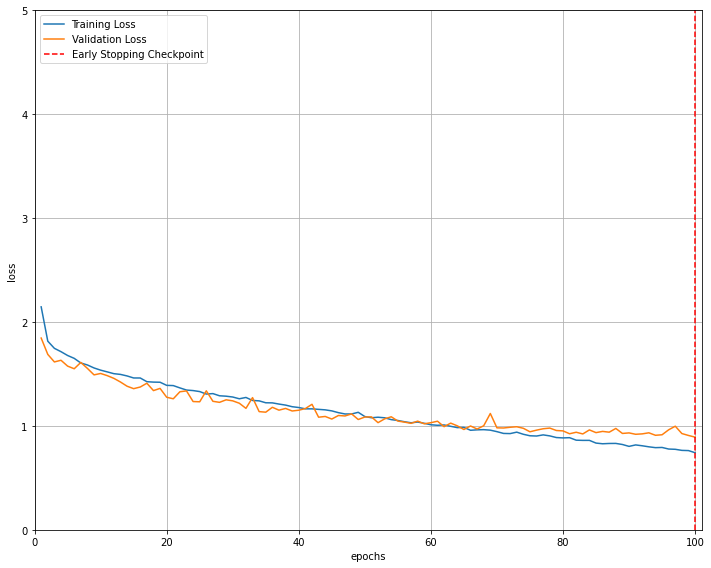

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:12<00:00,  6.14it/s]

Test Loss: 0.8920, Accuracy: 70.00%


(0.8919844068527222, 70.0)